In [226]:
from transformers import pipeline
from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from datasets import load_dataset


In [227]:
# Auxiliary functions
def sanity_check():
    pass

## Descriptive Analysis and Pre-processing of the Data

In [228]:
df = pd.read_csv('stock_data.csv')
df.head(10)

,Text,Sentiment
0,Kickers on my watchlist XIDE TIT SOQ PNK CPW B...,1
1,user: AAP MOVIE. 55% return for the FEA/GEED i...,1
2,user I'd be afraid to short AMZN - they are lo...,1
3,MNTA Over 12.00,1
4,OI Over 21.37,1
5,PGNX Over 3.04,1
6,AAP - user if so then the current downtrend wi...,-1
7,Monday's relative weakness. NYX WIN TIE TAP IC...,-1
8,GOOG - ower trend line channel test & volume s...,1
9,AAP will watch tomorrow for ONG entry.,1


### 1. Observe the number of sentiment to handle data imbalance
- analysis: data is slightly imbalanced with a 2:3 ratio
- action: use downsampling to balance the data (caveat: loss of information)

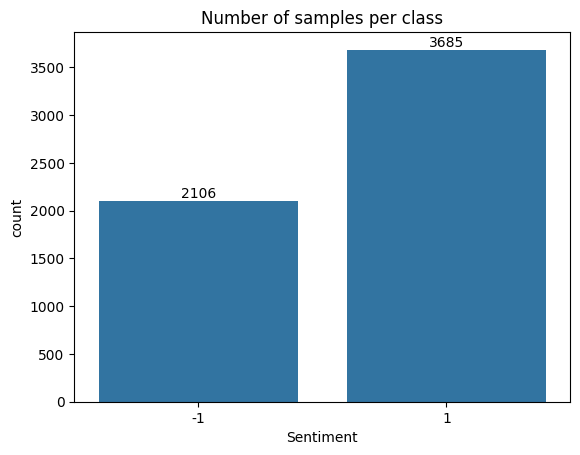

In [229]:
def check_class_imbalance(df):
    '''print out the number of samples per class'''
    
    ax = sns.countplot(x='Sentiment', data=df)
    ax.set_title('Number of samples per class')
    ax.bar_label(ax.containers[0])
    
check_class_imbalance(df)

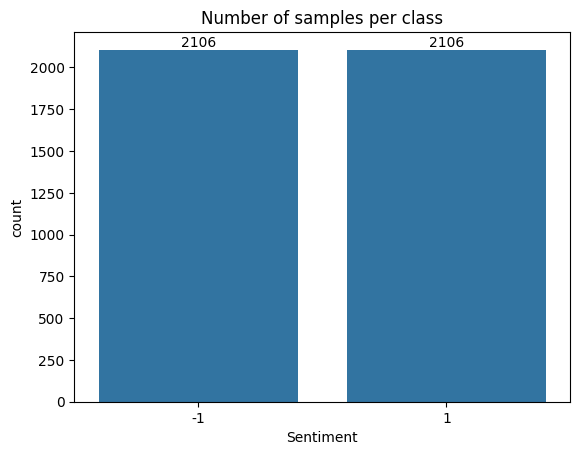

In [230]:
# execution of down sampling 
def down_sampling_to_equal_amount(df):
    '''downsampling to equal amount of samples for each class, index will be reset'''

    n_samples = df.Sentiment.value_counts().min()
    df_copy = df.groupby('Sentiment').apply(lambda x: x.sample(n_samples)).reset_index(drop=True)
    
    return df_copy.sample(frac=1)

df = down_sampling_to_equal_amount(df)
check_class_imbalance(df)

### 2. Observe the length of input text
- length analysis: the length of each input is almost symmetrically distributed between 2 and 32; 
    - no significant outliers
    - no significant difference between the length of 1 and -1 sentiment labels
- action : None, padding will be done together with data preprocessing before training


In [231]:
def print_range_of_text_length(df):
    '''print out the range of text length'''
    
    df['text_length'] = df['Text'].apply(lambda x: len(x.split()))
    print(f"Range of text length: {df['text_length'].min()} - {df['text_length'].max()}")

print_range_of_text_length(df)

Range of text length: 2 - 32


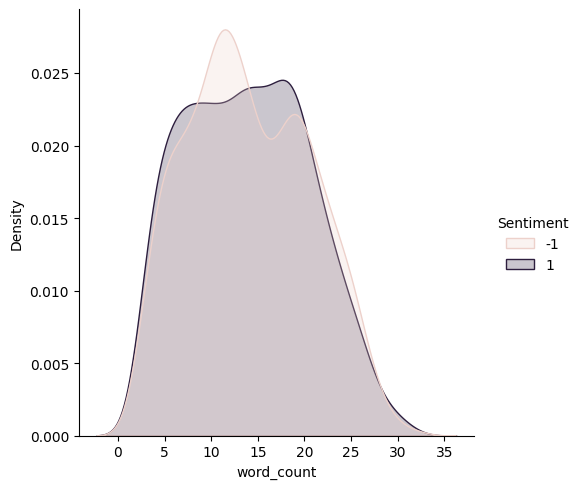

In [232]:
def plot_word_distribution(df):
    '''plot the distribution of the number of words in each sample'''
    
    df['word_count'] = df['Text'].apply(lambda x: len(x.split()))
    ax = sns.displot(data=df, x='word_count', hue='Sentiment', kind='kde', fill=True)
    ax.set_titles('Distribution of number of words in each sample')

plot_word_distribution(df)

### 3. Observe the number of unique charaters in the input text
- action: None, can be done by pre-trained model from hugging face

/Users/pangyen/anaconda3/envs/bert-venv/lib/python3.10/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 157 (\x9d) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/pangyen/anaconda3/envs/bert-venv/lib/python3.10/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 129 (\x81) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


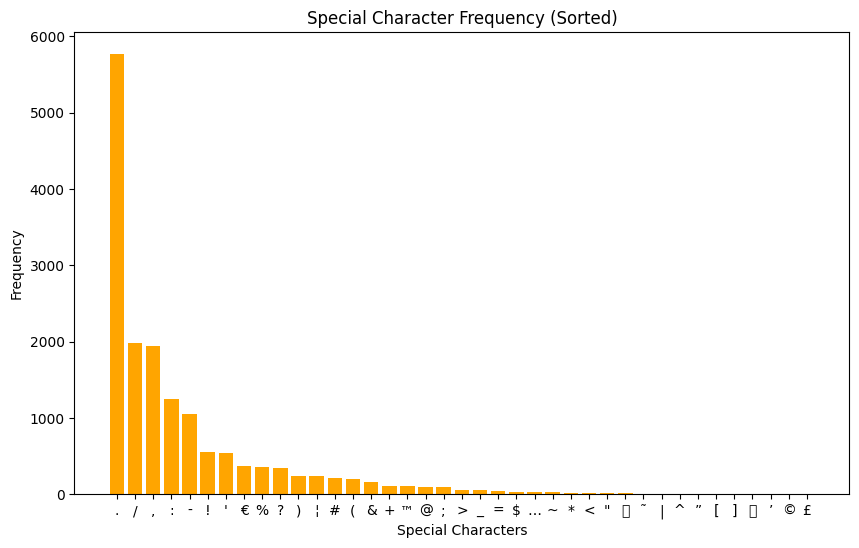

In [233]:
from collections import Counter

def plot_special_character_frequency(df):
    '''plot the frequency of special characters'''
    
    all_text = ''.join(df['Text'])
    special_char_counter = Counter(char for char in all_text if not char.isalnum() and not char.isspace())
    sorted_special_chars = sorted(special_char_counter, key=special_char_counter.get, reverse=True)
    sorted_counts = [special_char_counter[char] for char in sorted_special_chars]

    # Plot the occurrences of different special characters
    plt.figure(figsize=(10, 6))
    plt.bar(sorted_special_chars, sorted_counts, color='orange')
    plt.title('Special Character Frequency (Sorted)')
    plt.xlabel('Special Characters')
    plt.ylabel('Frequency')
    plt.show()

plot_special_character_frequency(df)

## Import pre-trained model from hugging face

In [234]:
# Load the tokenizer and model
from transformers import RobertaTokenizer, RobertaForSequenceClassification

tokenizer = RobertaTokenizer.from_pretrained('roberta-base')
model = RobertaForSequenceClassification.from_pretrained('roberta-base', num_labels=2)

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.weight', 'classifier.out_proj.weight', 'classifier.dense.bias', 'classifier.out_proj.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


## Data Preprocessing for BERT
1. Replace the -1 sentiment label with 0 to be consistent with the BERT model
2. Train test split
3. Tokenize the input text and wrap them into HuggingFace dataset

In [235]:
from sklearn.model_selection import train_test_split
from datasets import Dataset

# 1. replace -1 as 0
df['Sentiment'] = df['Sentiment'].replace(-1, 0) 

# 2. Split the data into training and testing
train_df, test_df = train_test_split(df, test_size=0.1, random_state=40)

# 3. Tokenize the dataset
train_tokenized = tokenizer(train_df["Text"].tolist(), truncation=True, padding=True)
test_tokenized = tokenizer(test_df["Text"].tolist(), truncation=True, padding=True)

# 4. Create datasets
train_dataset = Dataset.from_dict({"input_ids": train_tokenized["input_ids"], "attention_mask": train_tokenized["attention_mask"], "label": train_df["Sentiment"]})
test_dataset = Dataset.from_dict({"input_ids": test_tokenized["input_ids"], "attention_mask": test_tokenized["attention_mask"], "label": test_df["Sentiment"]})

Validation of the data preprocessing:

In [236]:
# Display a few samples from the training dataset
print("Training Dataset:")
for i in range(5):  # Display the sentiment labels for the first 5 samples
    sample = train_dataset[i]
    print(f"Sample {i + 1}: Text - {sample['input_ids']}, Sentiment - {sample['label']}")

# Display a few samples from the testing dataset
print("\nTesting Dataset:")
for i in range(5):  # Display the sentiment labels for the first 5 samples
    sample = test_dataset[i]
    print(f"Sample {i + 1}: Text - {sample['input_ids']}, Sentiment - {sample['label']}")


Training Dataset:
Sample 1: Text - [0, 534, 18375, 4270, 47266, 229, 1173, 1688, 163, 4911, 1543, 18, 9846, 598, 7238, 832, 1260, 6710, 4082, 415, 50118, 13082, 640, 90, 4, 876, 73, 28732, 1301, 428, 10245, 298, 134, 673, 406, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], Sentiment - 0
Sample 2: Text - [0, 534, 9332, 534, 11383, 202, 259, 111, 475, 7282, 1411, 1275, 380, 98, 473, 42, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], Sentiment - 0
Sample 3: Text - [0, 10836, 5, 13382, 9481, 11363, 1780, 10, 31885, 6149, 1527, 470, 3061, 5149, 116, 1437, 1437, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], Sentiment - 1
Sample 4: Text - [0, 250, 591, 449, 32925, 111, 44660, 34437, 5567, 6622, 117, 449, 32925, 10619, 1437, 14

## Fine-Tuning BERT

In [237]:
from transformers import DataCollatorWithPadding
from sklearn.metrics import accuracy_score, confusion_matrix
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

import evaluate
accuracy = evaluate.load("accuracy")

def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    
    # Compute the confusion matrix
    conf_mat = confusion_matrix(labels, predictions)
    
    # Print or return the confusion matrix
    print("Confusion Matrix:")
    print(conf_mat)
    
    # Return a dictionary with additional metrics if needed
    return accuracy.compute(predictions=predictions, references=labels)

# Training arguments
training_args = TrainingArguments(
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    output_dir="./sentiment_model",
    learning_rate=1e-5,
    num_train_epochs=6,
    weight_decay=0.01,
    evaluation_strategy="epoch",
    save_strategy="epoch",
)

# Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
)


## Training and Evaluation

In [238]:
trainer.train()

  0%|          | 0/2844 [00:00<?, ?it/s]

  0%|          | 0/53 [00:00<?, ?it/s]

Checkpoint destination directory ./sentiment_model/checkpoint-474 already exists and is non-empty.Saving will proceed but saved results may be invalid.


Confusion Matrix:
[[174  39]
 [ 46 163]]
{'eval_loss': 0.44848382472991943, 'eval_accuracy': 0.7985781990521327, 'eval_runtime': 1.3483, 'eval_samples_per_second': 312.976, 'eval_steps_per_second': 39.307, 'epoch': 1.0}
{'loss': 0.5885, 'learning_rate': 8.241912798874826e-06, 'epoch': 1.05}


  0%|          | 0/53 [00:00<?, ?it/s]

Checkpoint destination directory ./sentiment_model/checkpoint-948 already exists and is non-empty.Saving will proceed but saved results may be invalid.


Confusion Matrix:
[[177  36]
 [ 39 170]]
{'eval_loss': 0.5157855153083801, 'eval_accuracy': 0.8222748815165877, 'eval_runtime': 1.4358, 'eval_samples_per_second': 293.91, 'eval_steps_per_second': 36.913, 'epoch': 2.0}
{'loss': 0.4157, 'learning_rate': 6.483825597749649e-06, 'epoch': 2.11}


  0%|          | 0/53 [00:00<?, ?it/s]

Checkpoint destination directory ./sentiment_model/checkpoint-1422 already exists and is non-empty.Saving will proceed but saved results may be invalid.


Confusion Matrix:
[[178  35]
 [ 43 166]]
{'eval_loss': 0.6775554418563843, 'eval_accuracy': 0.8151658767772512, 'eval_runtime': 1.4359, 'eval_samples_per_second': 293.902, 'eval_steps_per_second': 36.912, 'epoch': 3.0}
{'loss': 0.3776, 'learning_rate': 4.725738396624473e-06, 'epoch': 3.16}


  0%|          | 0/53 [00:00<?, ?it/s]

Checkpoint destination directory ./sentiment_model/checkpoint-1896 already exists and is non-empty.Saving will proceed but saved results may be invalid.


Confusion Matrix:
[[175  38]
 [ 35 174]]
{'eval_loss': 0.8073132634162903, 'eval_accuracy': 0.8270142180094787, 'eval_runtime': 1.4643, 'eval_samples_per_second': 288.2, 'eval_steps_per_second': 36.196, 'epoch': 4.0}
{'loss': 0.3005, 'learning_rate': 2.967651195499297e-06, 'epoch': 4.22}


  0%|          | 0/53 [00:00<?, ?it/s]

Checkpoint destination directory ./sentiment_model/checkpoint-2370 already exists and is non-empty.Saving will proceed but saved results may be invalid.


Confusion Matrix:
[[177  36]
 [ 46 163]]
{'eval_loss': 0.951352059841156, 'eval_accuracy': 0.8056872037914692, 'eval_runtime': 1.4048, 'eval_samples_per_second': 300.407, 'eval_steps_per_second': 37.729, 'epoch': 5.0}
{'loss': 0.2477, 'learning_rate': 1.2095639943741212e-06, 'epoch': 5.27}


  0%|          | 0/53 [00:00<?, ?it/s]

Checkpoint destination directory ./sentiment_model/checkpoint-2844 already exists and is non-empty.Saving will proceed but saved results may be invalid.


Confusion Matrix:
[[180  33]
 [ 45 164]]
{'eval_loss': 0.9925757646560669, 'eval_accuracy': 0.8151658767772512, 'eval_runtime': 1.3834, 'eval_samples_per_second': 305.05, 'eval_steps_per_second': 38.312, 'epoch': 6.0}
{'train_runtime': 594.6545, 'train_samples_per_second': 38.241, 'train_steps_per_second': 4.783, 'train_loss': 0.3640892871153841, 'epoch': 6.0}


TrainOutput(global_step=2844, training_loss=0.3640892871153841, metrics={'train_runtime': 594.6545, 'train_samples_per_second': 38.241, 'train_steps_per_second': 4.783, 'train_loss': 0.3640892871153841, 'epoch': 6.0})

1. model: 
distilbert-base-uncased, batch_size=8, learning_rate=1e-5
{'train_runtime': 293.6624, 'train_samples_per_second': 77.436, 'train_steps_per_second': 9.685, 'train_loss': 0.32372328064780365, 'epoch': 6.0}

2. model: roberta-base, batch_size=8, learning_rate=1e-5
{'eval_loss': 0.9408127665519714,
 'eval_accuracy': 0.8199052132701422,
 'eval_runtime': 2.0012,
 'eval_samples_per_second': 210.876,
 'eval_steps_per_second': 26.484,
 'epoch': 6.0}

 3. model: bert-base-uncased, batch_size=8, learning_rate=1e-5
 {'eval_loss': 0.9435577988624573,
 'eval_accuracy': 0.8293838862559242,
 'eval_runtime': 1.2172,
 'eval_samples_per_second': 346.696,
 'eval_steps_per_second': 43.542,
 'epoch': 6.0}

 4. bert-base-cased, batch_size=8, learning_rate=1e-5
 {'eval_loss': 0.5547063946723938,
 'eval_accuracy': 0.7748815165876777,
 'eval_runtime': 1.4587,
 'eval_samples_per_second': 289.303,
 'eval_steps_per_second': 36.334,
 'epoch': 3.0}

In [239]:
results = trainer.evaluate()

  0%|          | 0/53 [00:00<?, ?it/s]

Confusion Matrix:
[[180  33]
 [ 45 164]]


In [243]:
results

{'eval_loss': 0.9925757646560669,
 'eval_accuracy': 0.8151658767772512,
 'eval_runtime': 1.3434,
 'eval_samples_per_second': 314.12,
 'eval_steps_per_second': 39.451,
 'epoch': 6.0}

In [244]:
print("Final accuracy:", results["eval_accuracy"])

Final accuracy: 0.8151658767772512
